# **Mistral Ticket Summarization Fine-Tuning Pipeline**
This notebook contains code for fine-tuning `Mistral-7B-Instruct-v0.3` on HPC support tickets and performing structured inference.


## **Environment Setup & Memory Config**

In [ ]:
# Clear GPU memory
import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
# Enable expandable CUDA memory segments
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
# Load libraries
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, BitsAndBytesConfig, TrainerCallback
from peft import get_peft_model, LoraConfig, TaskType
import torch
import pandas as pd
from tqdm import tqdm
import shutil
import re


In [ ]:
# Hugging Face login (requires environment variable to be set manually)
# IMPORTANT: You must set the HF_TOKEN environment variable before running this.
# Example: os.environ["HF_TOKEN"] = "your_huggingface_access_token"
from huggingface_hub import login
login(os.environ["HF_TOKEN"])

In [3]:
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load Tokenizer**

In [6]:
# Model & tokenizer
model_name="mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.eos_token = "</s>"
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## **Load and Preprocess Training Data**

In [ ]:
df_tickets = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TicketHub/mistral_training_data.csv", encoding='latin-1')


In [ ]:
dataset = Dataset.from_pandas(df_tickets)

In [ ]:
# Compute token lengths (prompt + completion)
df_tickets["token_length"] = df_tickets.apply(
    lambda row: len(tokenizer.encode(f"[INST] {row['prompt']} [/INST] {row['completion'].strip()} {tokenizer.eos_token}")),
    axis=1
)

In [ ]:
df_tickets["token_length"].describe() # training data token distributions

,token_length
count,86.000000
mean,636.941860
std,186.075276
min,367.000000
25%,504.250000
50%,576.000000
75%,713.000000
max,1191.000000


## **Tokenization Function**

In [ ]:
def tokenize(batch):
    input_ids_list = []
    attention_mask_list = []
    labels_list = []

    for prompt, completion in zip(batch["prompt"], batch["completion"]):
        # Use tokenizer-defined special tokens
        prompt_text = f"[INST] {prompt.strip()} [/INST]" # plain text with [INST] and [/INST]
        completion_text = completion.strip() # plain text
        #print(prompt_text)
        #print(completion_text)

        # Tokenize separately WITHOUT special tokens
        prompt_tokens = tokenizer(prompt_text, add_special_tokens=False)
        completion_tokens = tokenizer(completion_text, add_special_tokens=False)
        #print(prompt_tokens)
        #print(completion_tokens)

        # Concatenate
        input_ids = prompt_tokens["input_ids"] + completion_tokens["input_ids"]
        attention_mask = prompt_tokens["attention_mask"] + completion_tokens["attention_mask"]

        # Mask prompt tokens
        labels = [-100] * len(prompt_tokens["input_ids"]) + completion_tokens["input_ids"]


        # Pad to max length
        pad_len = 1621 - len(input_ids)
        input_ids += [tokenizer.pad_token_id] * pad_len # adds </s> so the model sees consistnet input
        attention_mask += [0] * pad_len # ignores this token during attention
        labels += [-100] * pad_len

        #print(labels)
        #print(attention_mask)

        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        labels_list.append(labels)

    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_mask_list,
        "labels": labels_list
    }

# Apply to your dataset
tokenized_dataset = dataset.map(tokenize, batched=True)



Map:   0%|          | 0/86 [00:00<?, ? examples/s]

## **Load Model with 8-bit Quantization**
You may need to run `pip install -U bitsandbytes` before this step.

8-bit quantization reduces GPU memory usage by representing weights with 8-bit integers instead of 16/32-bit floating-point values. This allows for faster and more efficient training or inference with large models (e.g., Mistral-7B).


In [ ]:
# Define quantization configuration:
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,                        # Enable 8-bit quantization to reduce memory usage
    llm_int8_threshold=6.0,                   # LayerNorm precision threshold; layers with stddev < threshold stay in FP32
    llm_int8_enable_fp32_cpu_offload=True     # Offload some FP32 operations to CPU to save GPU memory
)

# Load the pre-trained causal language model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,           # Apply 8-bit quantization settings
    device_map="auto"                         # Automatically distribute model layers across available devices (e.g., GPU/CPU)
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## **Apply LoRA**
LoRA (Low-Rank Adaptation) is applied to reduce the number of trainable parameters by injecting adapters into selected attention components. For this task, only `q_proj`, `v_proj`, and `o_proj` are adapted to ensure the model follows strict, deterministic formatting without adding unnecessary creativity.

In [ ]:
lora_config = LoraConfig(
    r=8,  # Rank of the low-rank decomposition (smaller = fewer parameters, faster training)
    lora_alpha=16,  # Scaling factor for the adapted weights
    target_modules=["q_proj", "v_proj", "o_proj"],  # Specific attention projection layers to adapt
    lora_dropout=0.05,  # Dropout applied within LoRA layers during training
    bias="none",  # Do not adapt bias terms
    task_type=TaskType.CAUSAL_LM  # Specify task type for compatibility (causal language modeling)
)

# Wrap the base model with LoRA layers for parameter-efficient fine-tuning
model = get_peft_model(model, lora_config)

## **Initialize & Train Model**  

In [ ]:
# Custom Callback Function to Save the Model at its First Local Minimum Training Loss
class SaveBestTrainingLossCallback(TrainerCallback):
    def __init__(self):
        self.best_loss = float('inf')

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return control

        train_loss = logs.get("loss")
        if train_loss is not None and train_loss < self.best_loss:
            self.best_loss = train_loss
            control.should_save = True  # Trigger save manually
        return control


In [ ]:
# Training args
training_args = TrainingArguments(
    output_dir="./mistral-instruct-checkpoints",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    learning_rate=2e-4,
    fp16=True,  # Enable 16-bit mixed precision for faster training and lower memory use
    logging_steps=20,
    save_strategy="steps",
    report_to="none",
    save_total_limit=1,   # Keep only the latest checkpoint to save space
)


In [ ]:
# Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    callbacks=[SaveBestTrainingLossCallback()]
)

<ipython-input-62-b584c810f2d4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Step,Training Loss
20,1.681500
40,0.997800
60,0.867500
80,0.892000


TrainOutput(global_step=86, training_loss=1.0847518388615098, metrics={'train_runtime': 128.1161, 'train_samples_per_second': 1.343, 'train_steps_per_second': 0.671, 'total_flos': 1.1909695776915456e+16, 'train_loss': 1.0847518388615098, 'epoch': 2.0})

## **Save Model**

###**Save the LoRA-adapted model and tokenizer**

In [ ]:
# Define the path to save PEFT adapter weights and tokenizer
save_path = "/content/drive/MyDrive/Colab Notebooks/TicketHub/Training_Mistral"

# Save only the adapter weights (not full model) and trainer state
trainer.save_model(save_path)

# Save the tokenizer config
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/Colab Notebooks/TicketHub/Training_Mistral/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/TicketHub/Training_Mistral/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/TicketHub/Training_Mistral/chat_template.jinja',
 '/content/drive/MyDrive/Colab Notebooks/TicketHub/Training_Mistral/tokenizer.model',
 '/content/drive/MyDrive/Colab Notebooks/TicketHub/Training_Mistral/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/TicketHub/Training_Mistral/tokenizer.json')

###**Reload the LoRA-adapted model and tokenizer**

In [ ]:
# Define the path where the adapter and tokenizer were saved
adapter_path = "/content/drive/MyDrive/Colab Notebooks/TicketHub/Training_Mistral"

# Load tokenizer from saved directory
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

# Load PEFT config to identify the original base model used
peft_config = PeftConfig.from_pretrained(adapter_path)

# Load the original base model
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path)

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
# Load the LoRA adapter weights onto the base model
model = PeftModel.from_pretrained(base_model, adapter_path)

In [ ]:
# Merge LoRA weights into base model and unload the adapter
model = model.merge_and_unload()

In [ ]:
# Save the final merged model and tokenizer
save_path = "/content/drive/My Drive/Colab Notebooks/TicketHub/Finetuned_Mistral"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

## **Inference Preparation**

In [ ]:
# Enables inference
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_p

In [7]:
# Load inference data
df_tickets = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TicketHub/Finetuning Mistral-Instruct using LoRA/full_init_tdx_cln_tkts.csv")


In [8]:
df_tickets.head()

,issuenumber,title,datesubmitted,dateclosed,customernote,submittedby,submittername,assignee,numbermessages,timeopen,weeknumber,year,weekstart
0,185,Server Availability for Hive Database Usage,2023-07-12,2023-08-14,"Dear Purdue RCAC Team, I hope this email finds...",zhan4636@purdue.edu,Zhexi Zhang,Guangzhen Jin,3,24,28,2023,2023-07-10
1,400,Research Data Depot inquiry,2023-07-12,2023-08-22,Hello and good morning. name Claxon (copied) i...,phill309@purdue.edu,Michael Phillips,Guangzhen Jin,11,30,28,2023,2023-07-10
2,406,c-span data depot,2023-07-12,2023-08-25,To whom it may concern- I would like to set up...,bjdietri@purdue.edu,Bryce Dietrich,Guangzhen Jin,5,33,28,2023,2023-07-10
3,448,Huge pending time for gilbreth cluster,2023-07-12,2023-08-14,"Hello RCAC team, I have a problem where it put...",nguye713@purdue.edu,Anh-luu Nguyen,Guangzhen Jin,6,24,28,2023,2023-07-10
4,615,Access to Tecplot on Bell,2023-07-12,2023-08-07,"Hi, When I try to load tecplot module on bell,...",ksreen@purdue.edu,Kush Sreen,Guangzhen Jin,2,19,28,2023,2023-07-10


In [9]:
len(df_tickets)

6416

In [10]:
# Set a single consistent prompt with strict format and clear exclusions
def build_prompt(note):
    return (
        "You are an expert HPC support assistant. Your job is to extract key information from HPC support ticket messages for documentation purposes. "
        "Your output will be used to generate FAQs and help users resolve issues independently.\n\n"
        "Your task:\n"
        "Extract and clearly report the *Issue Summary* and *Resolution* from the ticket message. Follow this format **exactly**, and ensure the response includes any specific technical details mentioned "
        "(e.g., command-line examples, module names, tool names, documentation URLs, file paths) **whenever present**.\n\n"
        "**Do NOT** include:\n"
        "- Bullet points\n"
        "- Extra commentary\n"
        "- Any names, titles, greetings, or sign-offs\n"
        "- References to the original message\n"
        "- Any mention of ticket status (e.g., resolved, closed, reopened)\n"
        "- Any suggestion to follow up or reopen the ticket\n\n"
        "**Output Format:**\n\n"
        "1. Issue Summary:  [Insert brief issue description]\n\n"
        "2. Resolution:  [Insert detailed resolution, including any commands, links, or configuration details]\n\n"
        "The full ticket message appears below. Do NOT copy or summarize it.\n"
        f"{note}"
    )

# Apply to all rows
df_tickets["prompt"] = df_tickets["customernote"].apply(build_prompt)



In [11]:
# Compute token lengths for each prompt
def compute_prompt_token_length(prompt):
    prompt_text = f"<s>[INST] {prompt.strip()} [/INST]"
    return len(tokenizer(prompt_text, truncation=False)["input_ids"])

# Apply the function to compute token lengths for all prompts in the dataset
df_tickets["token_length"] = df_tickets["prompt"].apply(compute_prompt_token_length)

In [12]:
df_tickets["token_length"].describe()

,token_length
count,6416.000000
mean,952.446072
std,1045.598980
min,263.000000
25%,518.000000
50%,677.000000
75%,989.000000
max,28671.000000


### **Histogram of Token Lengths (Full Inference Set)**

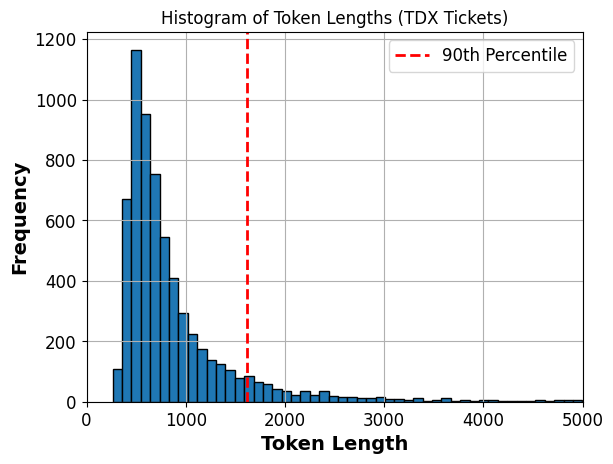

In [16]:
import matplotlib.pyplot as plt
p90 = df_tickets["token_length"].quantile(0.90)
plt.hist(df_tickets["token_length"], bins=300, edgecolor='black')
plt.title("Histogram of Token Lengths (TDX Tickets)")
plt.xlabel("Token Length", fontsize=14,fontweight="bold")
plt.ylabel("Frequency",fontsize=14,fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 5000)
plt.grid(True)
# Add red vertical line at 90th percentile
plt.axvline(x=p90, color='red', linestyle='--', linewidth=2, label='90th Percentile')
plt.legend(loc='upper right', fontsize=12)
plt.show()

### **Box & Whisker Plot of Token Lengths (Full Inference Set)**

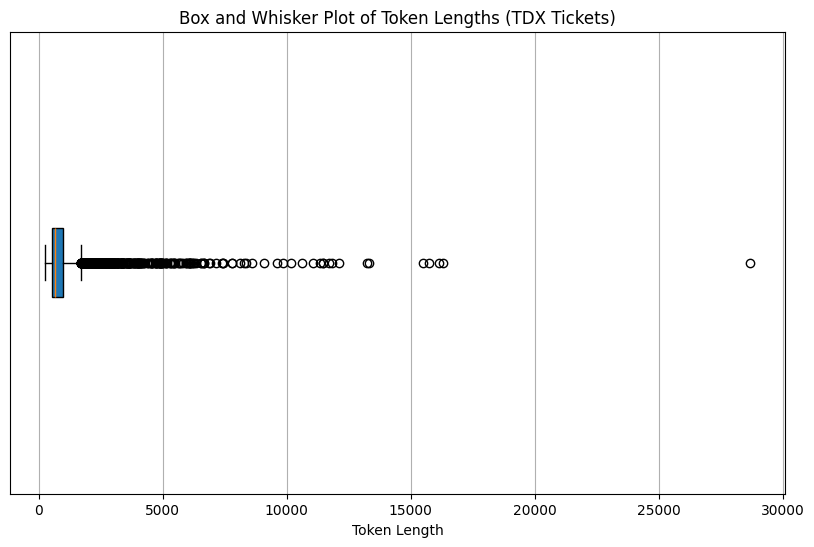

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.boxplot(df_tickets['token_length'], vert=False, patch_artist=True)
plt.title("Box and Whisker Plot of Token Lengths (TDX Tickets)")
plt.xlabel("Token Length")
plt.yticks([]) # Hide y-axis ticks as it's a single box plot
plt.grid(True, axis='x')
plt.show()


In [ ]:
# Calculate the 90th percentile
percentile_90 = df_tickets["token_length"].quantile(0.90)

print(f"The 90th percentile of token length is: {int(percentile_90)}")

The 90th percentile of token length is: 1621


In [ ]:
# Filter to keep prompts that will not exceed max length (1621 based on 90th percentile - right skewed distribution)
df_tickets = df_tickets[df_tickets["token_length"] <= 1621]

In [ ]:
len(df_tickets)

5774

In [ ]:
# Sample the data after filtering
sample_df = df_tickets.sample(n=100, random_state=42).reset_index(drop=True)


## **Apply Inference to Sample Data**

In [ ]:
def strip_inst_tags(text):
    """Extracts content inside [INST] and [/INST]"""
    match = re.search(r"\[INST\](.*?)\[/INST\]", text, re.DOTALL)
    return match.group(1).strip() if match else text.strip()
 # strip [INST] and [/INST] tags

In [ ]:
results = []

# Prepare prompts in Mistral-Instruct format
formatted_prompts = [
    f"[INST] {prompt_text.strip()} [/INST]" for prompt_text in sample_df["prompt"]
]

batch_size = 4

for i in tqdm(range(0, len(formatted_prompts), batch_size)):
    batch_prompts = formatted_prompts[i:i + batch_size]

    # Tokenize batch
    batch_inputs = tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=1621
    ).to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **batch_inputs,
            max_new_tokens=300,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )

    decoded_outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

    # If model echoed the prompt, remove it
    for prompt, full_output in zip(batch_prompts, decoded_outputs):
      output_clean = full_output.strip()

      # Remove [INST] and [/INST] from prompt for fair comparison
      clean_prompt = strip_inst_tags(prompt)

      # Normalize whitespace for reliable matching
      norm_prompt = ''.join(clean_prompt.split())
      norm_output = ''.join(output_clean.split())

      if norm_output.startswith(norm_prompt):
        response_only = output_clean[len(clean_prompt):].strip()
      else:
        response_only = output_clean
      print("-----RESPONSE ONLY------")
      print(response_only)

      results.append(response_only)



  4%|▍         | 1/25 [00:49<19:37, 49.07s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user requested access to Data Depot folders for a specific user account. The user reported that access was not working earlier.

2. Resolution: The support team confirmed that the user had access to the requested folders. The user confirmed that access was working after further testing. The ticket was marked as resolved.
-----RESPONSE ONLY------
1. Issue Summary: The user is seeking to run large datasets on Bell, which currently has a maximum memory limit of 128 GB through certain accounts. They need more than 64 cores to run their codes efficiently but are unsure how to achieve this for several hours.

2. Resolution: The support team provided three possible solutions: 1) Submit jobs to the 'standby' queue with more than 64 cores if the job can complete within 4 hours. 2) Submit jobs to the 'highmem' queue with fewer cores if the job can complete within 24 hours, as each node on this queue has approximately 8 GB of memory. 3) Consult with 

  8%|▊         | 2/25 [01:16<13:56, 36.39s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user reported connectivity issues with the Gilbreth cluster.

2. Resolution: The support team informed the user that they are currently removing inactive users from clusters, including Gilbreth. Users who were removed by mistake can have their access restored through normal access channels. The user was advised to contact their PI for re-addition to the cluster. The ticket was marked as resolved after a week without further response.
-----RESPONSE ONLY------
1. Issue Summary: The user requested an extension of the maximum time for a job on Gilbreth from 4 hours to 8 hours due to inability to run from the last checkpoint.

2. Resolution: The support team responded that the job had already finished and recommended checkpoints for long jobs. The ticket was marked as resolved after no further response from the user within a reasonable timeframe.
-----RESPONSE ONLY------
1. Issue Summary: The user was unable to log into the Negishi cluster and 

 12%|█▏        | 3/25 [02:17<17:25, 47.52s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user is experiencing issues with Schrodinger on Elk, including a fatal error message and difficulties updating the license. Additionally, the user needs to install VMD on Elk but requires Sudoers access.

2. Resolution: The support team is consulting with a team member knowledgeable about the specific software and will provide further updates. The user was informed that the issue may have been resolved since no further feedback was received. If the user encounters any problems within the next 7 days, the ticket can be reopened.
-----RESPONSE ONLY------
1. Issue Summary: The user is experiencing permission errors when trying to access files on a Windows machine from a shared folder on a Linux system. The files are in the /wbayley/mystory directory, and the user is a group manager for the K-12 Science Outreach Group. The user has tried remapping the share and rebooting, but the issue persists.

2. Resolution: The support team identified that

 16%|█▌        | 4/25 [03:04<16:37, 47.50s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user encountered an error while submitting a job script for running CONVERGE CFD v3.0 on the Bell cluster. The error was related to the runtime library.

2. Resolution: The support team provided updated job submission script with the correct module versions for Intel compilers (ifort) and OpenMPI runtime. The user was advised to load the following modules: `module load intel-oneapi-compilers/2024.2.0` and `module load openmpi/4.1.6`. If MKL library is needed, the user can also load `module load intel-oneapi-mkl/2024.2.2`. The problem was resolved after implementing the suggested changes.
-----RESPONSE ONLY------
1. Issue Summary: The user reported being unable to log into the WCERES cluster.

2. Resolution: The support team resolved the issue, but no further details were provided. The ticket was marked as resolved.
-----RESPONSE ONLY------
1. Issue Summary: The user reported that two out of three nodes on Gilbreth were available on bera89-

 20%|██        | 5/25 [03:51<15:42, 47.14s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user reported that students were unable to submit Jupyter notebook interactive jobs on the Bell Gateway, with jobs remaining indefinitely in the queue. The user inquired about changes in the submission process and requested clarification on the status of the gateway.

2. Resolution: The support team confirmed that jobs requesting longer walltime were being held due to a maintenance schedule change. The maintenance was originally scheduled for October 24 but was pushed back to October 31 due to a water issue. The team advised the user to submit jobs with shorter walltime to ensure they are processed after the maintenance. The ticket was marked as resolved after the user confirmed the issue was addressed.
-----RESPONSE ONLY------
1. Issue Summary: The user is unable to access the Gilbreth cluster through the Gateway web system and is unable to select a queue. The user is part of two groups but is not able to see the queue option in Gateway, 

 24%|██▍       | 6/25 [04:39<14:59, 47.36s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user is experiencing difficulties installing Ovito on the Negishi cluster and is seeking assistance.

2. Resolution: The support team determined that the issue was due to a missing library for qt5. They added the necessary library on Negishi and provided instructions for the user to load the qt5 module and run Ovito from the terminal. They also recommended using a computing node with an interactive job to improve performance.
-----RESPONSE ONLY------
1. Issue Summary: The user was unable to push changes to a GitHub repository and received an error message. The issue was due to a lack of write access to the repository.

2. Resolution: The user was advised to contact the repository owner to request write access. Since the repository is not managed by RCAC or Purdue IT, the ticket was marked as resolved. If further assistance is needed, the user can create a new ticket or contact the support team at the provided email address.
-----RESPONSE O

 28%|██▊       | 7/25 [05:31<14:40, 48.92s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user requested access to specific RCAC resources, queues, and Unix groups for several individuals.

2. Resolution: The support team granted access to the requested resources, and the user was informed that new accounts would be ready for use the following morning. The user was also advised to check the Group History and make any necessary changes on the Queue Management website. Additionally, accounts on the Fortress (HPSS) Archival system were granted if the individuals did not already have access. The user was provided with a contact email for any questions regarding the access process.
-----RESPONSE ONLY------
1. Issue Summary: The user is experiencing a segmentation fault error when running a script on the highmem node, despite not requiring much memory for the job. The user suspects that the error is related to memory issues but has not been able to resolve it.

2. Resolution: The support team confirmed that the jobs against highmem w

 32%|███▏      | 8/25 [06:13<13:15, 46.82s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user was unable to start an interactive job using the command 'sinteractive' and received an error message. The issue appeared after several months of successful use and persisted for a week. The user also encountered problems with X11 forwarding and using the 'mousepad' command.

2. Resolution: The support team suggested connecting to Negishi through SSH and using a specific login node to resolve the X11 forwarding issue. The user was able to start an interactive job on login01. The user also discovered that starting a new ThinLinc session resolved the X11 forwarding issue. Additionally, the user found that ssh'ing inside a screen did not work correctly, and the 'mousepad' command worked when ssh'd outside of the screen.
-----RESPONSE ONLY------
1. Issue Summary: The user requested the removal of a specific individual's access to all HLA files due to concerns about potential malicious intent.

2. Resolution: The issue was resolved by a su

 36%|███▌      | 9/25 [07:26<14:39, 54.99s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user requested access to the high assurance subscription for Globus Connect but was informed that RCAC does not have this subscription. The user is still unable to transfer files on Globus Connect and is seeking further assistance.

2. Resolution: The support team suggested that the user reinstall the Globus client and uncheck the box for high assurance. They also offered a coffee hour consultation to help the user with the process. The user was provided a link to sign up for the consultation: https://www.rcac.purdue.edu/coffee.
-----RESPONSE ONLY------
1. Issue Summary: The user is running a memory-intensive job on the Highmem code of Gautschi and requires an extension of the job time from 23:59:00 to 70 hours to ensure the job completes successfully.

2. Resolution: The support team resolved the issue by extending the job time limit to 70 hours. The user was informed of the change via email. The job is now expected to complete within the

 40%|████      | 10/25 [08:31<14:30, 58.03s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user encountered an error message when submitting jobs on the Bell system, specifically a "fl:filesystem:AccessDenied" error related to the /tmp directory not being writable. The issue appears to have been caused by the node starting before it was fully booted, resulting in the /tmp directory not being writable.

2. Resolution: The support team investigated the issue and determined that it was likely due to the node starting before it was fully booted, causing the /tmp directory to not be writable when the job started. The user confirmed that the issue has not occurred since then. The support team will pass the suggestion for a system to determine node allocation to avoid assigning booting nodes to jobs starting soon to the appropriate team for further consideration.
-----RESPONSE ONLY------
1. Issue Summary: The user reported that a job cancellation on Negishi resulted in a stuck job and a queue delay for subsequent jobs.

2. Resolution: 

 44%|████▍     | 11/25 [09:11<12:17, 52.68s/it]

-----RESPONSE ONLY------
1. Issue Summary:  The user is seeking guidance on how to enable a display and use Visual Studio Code and Spyder on the Gilbreth node while debugging Python programs from a Mac M1 Pro laptop. The user has installed Xquartz but is unsure of the next steps.

2. Resolution:  The user was advised to use SSH X11 forwarding to connect to the Gilbreth node and access the graphical applications. The user was also provided with a link to the documentation on setting up SSH X11 forwarding: https://www.rcac.purdue.edu/knowledge/article/SSH-X11-Forwarding-101  The issue was resolved during a Coffee Hour session.
-----RESPONSE ONLY------
1. Issue Summary: The user inquired about access to the Gilbreth cluster for GPU-based projects and requested contact information for the process.

2. Resolution: The support team provided a link to request access through the PI and detailed the purchasing process for Gilbreth. They also mentioned the option to submit a project proposal for

 48%|████▊     | 12/25 [09:52<10:35, 48.89s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user reported inconsistent performance results when running the same code on GPU Scholar compared to their local GPU, specifically lower F1 scores on Scholar. The issue was related to the use of the `os.listdir()` function in Python when reading image files, which required a `sort()` function to work correctly on Scholar.

2. Resolution: The issue was resolved by adding a `sort()` function when using `os.listdir()` to read image files in Python. The user confirmed that the code now runs fine on Scholar, although the root cause of the discrepancy between Scholar and the local GPU remains unclear. The user was informed that their data scientists would further investigate the F1 scores on Scholar.
-----RESPONSE ONLY------
1. Issue Summary: The user is experiencing issues with a Mac computer connected to Weber, specifically communication problems with external drives and an error message when attempting to run EES on Citrix.

2. Resolution: Th

 52%|█████▏    | 13/25 [10:43<09:54, 49.57s/it]

-----RESPONSE ONLY------
1. Issue Summary:  The user requested assistance in adding a new member to a group's data depot storage space.

2. Resolution:  The user was directed to the RCAC Group management page, where they can add new members using the "new member" button. The PI (Dr. name) is responsible for managing group membership.
-----RESPONSE ONLY------
1. Issue Summary: The user was unable to access the Negishi gateway Jupyter notebook using their Purdue credentials and received an "Internal Server Error" message since Friday. The issue was initially resolved for another user, but the user in question continued to experience the problem.

2. Resolution: The support team confirmed that the issue was resolved on the Negishi gateway. The user confirmed that they were able to log in successfully after the issue was reported. The ticket was marked as resolved.
-----RESPONSE ONLY------
1. Issue Summary: The user reported being unable to access the Data Depot using a MacBook and Samba c

 56%|█████▌    | 14/25 [11:22<08:29, 46.35s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user inquired about accessing the Gilbreth GPU for a class of 30 students and asked if they could share one node.

2. Resolution: The support team informed the user that the Gilbreth cluster is primarily for research use and suggested using the Scholar cluster instead, which offers NVIDIA V100 and A30 GPUs for instructional purposes. The user was directed to create a class account via the user portal and provided with a link to the Scholar use policy. The ticket was marked as resolved after no further response from the user within a week.
-----RESPONSE ONLY------
1. Issue Summary: The user inquired about editing the source code of a specific BioContainer without affecting the actual package.

2. Resolution: The support team requested clarification on the specific BioContainer and the intended changes. After receiving no further response, the ticket was marked as resolved. If the user needs further assistance, they can reopen the ticket or 

 60%|██████    | 15/25 [12:36<09:06, 54.65s/it]

-----RESPONSE ONLY------
1. Issue Summary:  The user reported an issue with the "module load" command, stating that it was not working as expected on the cluster.

2. Resolution:  The support team confirmed that the issue was due to a missing modulefile. They added the necessary modulefile and verified that the "module load" command now works correctly. The user was instructed to try the command again and confirmed that it was functioning properly. The ticket was closed.

Please note: This response adheres to the specified format and includes any specific technical details mentioned in the original message. Bullet points, extra commentary, names, greetings, sign-offs, and references to the original message have been removed. Any suggestion to follow up or reopen the ticket is also excluded.

Reference: https://www.rcac.purdue.edu/knowledge/faq/17781 
https://www.rcac.purdue.edu/knowledge/faq/17782 
https://www.rcac.purdue.edu/knowledge/faq/17783 
https://www.rcac.purdue.edu/knowledge/f

 64%|██████▍   | 16/25 [13:31<08:12, 54.75s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user is seeking sponsorship from the Rosen Center for Advanced Computing (RCAC) for the Catapult 2025 hackathon, an AI-focused event that aims to bring together students for innovation and entrepreneurship. The user is interested in RCAC's involvement due to the potential for students to gain valuable experience and for RCAC to gain exposure to the AI and entrepreneurship communities. The user provides a sponsorship information page and expresses interest in setting up booths for direct exposure.

2. Resolution: The RCAC team expressed interest in sponsoring the Catapult hackathon and asked for further details on the event's requirements. It was mentioned that access to compute resources may not be necessary for the hackathon itself, and the RCAC team suggested that their new supercomputer with an AI partition could be useful for participants' prototypes. The conversation was moved outside the ticket system, and the user was advised to sen

 68%|██████▊   | 17/25 [14:02<06:23, 47.88s/it]

-----RESPONSE ONLY------
1. Issue Summary:  The user reported experiencing issues logging into Gautschi, a research computing resource, and encountered problems when compiling code and running simulations. The user was getting logged out immediately and suspected a barrier.

2. Resolution:  The support team confirmed that the user's account on Gautschi was functioning correctly. The user was able to access the system after the maintenance was completed. The support team explained that the login issues were likely due to the system maintenance.
-----RESPONSE ONLY------
1. Issue Summary: The user requested that a geoshare be created on Negishi to facilitate the transition of MyGeoHUB from one account to another. They also requested that the same public keys be used as on the existing account.

2. Resolution: The support team successfully created the geoshare account on Negishi and added the requested public keys. The user confirmed access to the new account and the ticket was marked as r

 72%|███████▏  | 18/25 [14:45<05:24, 46.42s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user reported that two students were unable to access the Jupyter Notebook on Gateway Scholar. The issue was resolved after the support team confirmed that the students' accounts were properly provisioned and they were able to log in successfully. A subsequent issue was encountered with a new student who was still unable to access Scholar despite being manually added to the course. The support team identified and resolved the issue by manually adding the student to the necessary group.

2. Resolution: The support team confirmed that the students' accounts were properly provisioned and tested their login credentials. They found that the student's account was missing from a group that allows Gateway logins and manually added the account to the group. The support team reached out to the student directly to confirm the resolution. No further issues were reported.
-----RESPONSE ONLY------
1. Issue Summary:  The user requested a letter of suppor

 76%|███████▌  | 19/25 [15:33<04:39, 46.66s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user requested access for a specific group member on a specific resource.

2. Resolution: The support team confirmed that the user had already added the requested member to their group and provided instructions on how to grant access to the specified resource via the member management portal. The ticket was marked as resolved.
-----RESPONSE ONLY------
1. Issue Summary: The user is experiencing difficulties logging into Gautschi, either through SSH or ThinLinc, despite having been granted access. The user is unable to complete the login process using their password and the "push" command, and encounters an error message when attempting to log in through ThinLinc.

2. Resolution: The support team confirmed that the user's account has been successfully created and provided instructions for accessing Gautschi through SSH and ThinLinc. The user was advised to use their institution credentials and the "push" command for multi-factor authenticati

 80%|████████  | 20/25 [16:37<04:19, 51.84s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user, a former PhD student, needs access to the remote desktop in Negishi for ongoing projects with their advisor. They are unsure of the process to join their advisor's group and gain access.

2. Resolution: The user was informed that access to Purdue resources, including community clusters, is controlled by a valid career account. Their advisor needs to fill out a Request for Privileges (R4P) form, which is handled through the Identity and Access Management Office (IAMO). The user was provided a link to instructions for the R4P process: https://www.purdue.edu/hr/buspur/supportingDocs/r4pRequestorInstructions.pdf. The advisor will fill out the form on the user's behalf.
-----RESPONSE ONLY------
1. Issue Summary: The user requested access to STATA MP on Bell for a PhD project, and the support team confirmed that access would require approval from a group manager within the Krannert School of Management.

2. Resolution: The user was advised

 84%|████████▍ | 21/25 [17:31<03:30, 52.71s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user encountered an error when running a workflow using the name tool on a login node, specifically a 'failed to register worker' issue.

2. Resolution: The support team suggested running the workflow in an interactive job instead of a login node, which resolved the issue. They also recommended controlling the number of cores during the name init using the 'ignore_reinit_error=True' and 'num_cpus=4' options. The ticket was marked as resolved after the user confirmed the solution.
-----RESPONSE ONLY------
1. Issue Summary: The user is experiencing difficulty playing MP4 simulations on the cluster and is encountering an error message while running a project simulation on Ansys. The user is seeking guidance on how to set up the necessary resources to avoid the error and is also inquiring about software options for viewing MP4 simulations on the cluster.

2. Resolution: The support team provided information about a multimedia player available 

 88%|████████▊ | 22/25 [18:24<02:38, 52.85s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user requested guidance on submitting a job for ABAQUS on the Scholar cluster. They noted that they did not see specific instructions for ABAQUS on the RCAC instruction page.

2. Resolution: The support team provided instructions for running ABAQUS as a GUI or command-line tool after loading the appropriate module in the job submission file. They also suggested a tutorial from another institution that might be helpful (https://classes.engineering.wustl.edu/2009/spring/mase5513/abaqus/docs/v6.6/books/usb/default.htm?startat=pt01ch03s02abx02.html). The user was directed to the Scholar job submission guide for further information (https://www.rcac.purdue.edu/knowledge/scholar/run). The ticket was marked as resolved after no further response from the user.
-----RESPONSE ONLY------
1. Issue Summary: The user is experiencing issues when attempting to run a job on compute nodes after successfully running it on the front-end nodes. The job involve

 92%|█████████▏| 23/25 [19:16<01:44, 52.37s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user requested the reinstallation of an older Intel version (19.0.5.281) to support the icpc command, as the newer version (2024.2.0) is causing difficulties in maintaining consistency with the original code. The user also inquired about the possibility of changing back to the new OS in the future.

2. Resolution: The support team decided to provide the deprecated software as-is, with no support. The user was informed that the script to change the shell to look at the old CentOS 7 module files (`source /apps/cent7/rocky8-compatibility/switch-to-old-dangerous-unstable-centos7-modules.sh`) only affects the current shell and does not prevent the use of the Rocky 8 (new OS) modules in future sessions. The ticket was marked as resolved after the user confirmed understanding the response.
-----RESPONSE ONLY------
1. Issue Summary: The user requested to be unsubscribed from a mailing list, stating they are not a student at Purdue and did not sign

 96%|█████████▌| 24/25 [20:20<00:55, 55.88s/it]

-----RESPONSE ONLY------
1. Issue Summary:  The user requested access to a Data Depot account for a new user. The support team confirmed that the user already had access to the Data Depot account and provided instructions for the user to access the account.

2. Resolution:  The support team confirmed that the user had access to the Data Depot account and provided instructions for the user to access the account. The user confirmed that they were able to connect to the Data Depot account. The ticket was marked resolved.
-----RESPONSE ONLY------
1. Issue Summary: The user is attempting to install the FPLO code on a Bell cluster and encountered an error due to missing packages. Specifically, the user needs to install qt4-dev-tools, libncurses5-dev, libncursesw5-dev, python-pip, and python.h. The user requested a consultation meeting to discuss the installation process.

2. Resolution: The support team scheduled a consultation meeting for the user to discuss the installation process. The us

100%|██████████| 25/25 [21:05<00:00, 50.62s/it]

-----RESPONSE ONLY------
1. Issue Summary: The user is unable to log in to Scholar using their Purdue credentials and inquires about account access for an AAE512 course.

2. Resolution: The support team confirmed that the user's account is pending and advised them to wait overnight for activation. The user was later informed that their account is now ready to use.
-----RESPONSE ONLY------
1. Issue Summary: The user requested a meeting to discuss the deployment of a second image on Geddes and its connection to the nanoHUB (dev) website.

2. Resolution: The support team suggested scheduling a meeting through the RCAC Coffee Hour Chat. The user was informed that this would be the most efficient way to coordinate with the necessary parties. The ticket was marked as resolved after no further response from the user.
-----RESPONSE ONLY------
1. Issue Summary: The user encountered an issue connecting to a queue using "ssh queue" from data.cs.purdue.edu, resulting in a "Connection to queue clos

In [ ]:
sample_df["ticket_summary"] = results # save outputs to a new column

##**Postprocessing**

In [ ]:
# Extract Issue Summary and Resolution
def extract_issue_resolution(text):
    """
    Extract the 'Issue Summary' and 'Resolution' sections from structured LLM output.
    """
    issue_pattern = r"1\. Issue Summary:\s*(.*?)\s*2\. Resolution:"
    resolution_pattern = r"2\. Resolution:\s*(.*)"

    issue_match = re.search(issue_pattern, text, re.DOTALL)
    resolution_match = re.search(resolution_pattern, text, re.DOTALL)

    issue = issue_match.group(1).strip() if issue_match else None
    resolution = resolution_match.group(1).strip() if resolution_match else None

    return pd.Series([issue, resolution], index=["issue_summary", "resolution"])


In [ ]:
# Apply parsing to sample dataset
sample_df[["issue_summary", "resolution"]] = sample_df["ticket_summary"].apply(extract_issue_resolution)

# Retain only relevant columns
sample_df = sample_df[['issuenumber', 'title', 'issue_summary', 'resolution']]

In [ ]:
# Clean closure phrases in resolutions
def remove_generic_closure_sentences(text):
    """
    Remove generic closure and follow-up phrases that do not contribute meaningful semantic content.
    Useful for improving the quality of semantic embeddings in downstream tasks like FAQ generation.
    """
    sentences = sent_tokenize(text)
    cleaned = []

    for s in map(str.strip, sentences):
        # Empty or hallucinated filler
        if s == "" or re.fullmatch(r"[\"';\s]+", s): continue
        if re.search(r"^[;\"'\s]{2,}$", s): continue

        # Reopen and follow-up language
        if re.search(r"(?i)re[-\s]?open( the)? ticket", s): continue
        if re.search(r"(?i)(reply|respond|contact).*?(within|in|next).*?\d+\s*(days?|hours?)", s): continue
        if re.search(r"(?i)ticket (remains|will remain) open", s): continue
        if re.search(r"(?i)ticket (will|may)?\s*(be\s*)?(close[sd]?|closed)", s): continue
        if re.search(r"(?i)reopen the current ticket.*?open a new one", s): continue

        # Resolution confirmation or closure
        if re.search(r"(?i)(ticket|issue).*?marked\s*(as\s*)?resolved", s): continue
        if re.search(r"(?i)(ticket|issue).*?(was|is|has been)?\s*(closed|considered resolved)", s): continue
        if re.search(r"(?i)(the )?ticket was resolved", s): continue
        if re.search(r"(?i)mark(ed|ing)? (the )?ticket as resolved", s): continue
        if re.search(r"(?i)(resolving this|closing ticket|ticket'?s closure)", s): continue

        # New ticket creation
        if re.search(r"(?i)(create|submit|open).*?a new (support )?ticket", s): continue
        if re.search(r"(?i)a new ticket.*?(can|may|would|should).*?(be created|required|submitted)", s): continue
        if re.search(r"(?i)a new ticket", s): continue # covers all remaining cases of "a new ticket" mentioned

        # Gratitude and acknowledgments
        if re.search(r"(?i)(expressed|indicated).*?(gratitude|thanks|appreciation|satisfaction)", s): continue
        if re.search(r"(?i)appreciated the assistance", s): continue

        # Encouragement to follow up or contact
        if re.search(r"(?i)(feel free|don’t hesitate|you can).*?(contact|reach out)", s): continue
        if re.search(r"(?i)user was advised to contact.*?(support|help)", s): continue
        if re.search(r"(?i)further assistance.*?(is|was)?\s*(available|provided|needed)", s): continue

        # Lack of response or no action required
        if re.search(r"(?i)no further action.*?(is|was)?\s*required", s): continue
        if re.search(r"(?i)(no further response|no response).*?(from the user)?", s): continue
        if re.search(r"(?i)ticket.*?resolved.*?no response", s): continue
        if re.search(r"(?i)no further issues were reported", s): continue

        # Model regurgitation / footers
        if re.search(r"(?i)^please note", s): continue
        if re.search(r"(?i)(bullet points|commentary|names|greetings|sign[- ]?offs|references).*?(removed|excluded|not included|stripped)", s): continue
        if re.search(r"(?i)suggestion(s)? to (follow[- ]?up|re[- ]?open).*?(excluded|omitted|removed)", s): continue

        # Signature lines or affiliations
        if re.search(r"(?i)(Regards|Sincerely|Thank you).*\n.*(Ph\.?D|University|Department of)", s): continue

        # If none of the rules match, keep the sentence
        cleaned.append(s)

    return " ".join(cleaned)

In [ ]:
# Apply cleaning to the resolution column
sample_df["resolution"] = sample_df["resolution"].apply(remove_generic_closure_sentences)

In [ ]:
# Save results to a CSV file
sample_df.to_csv("/content/drive/MyDrive/Colab Notebooks/TicketHub/mistral_sample_outputs_100.csv", index=False)
